# Exploration of advection-diffusion versus threshold model of landscape development.

## Advection-Diffusion model exploration

We first plot the topography that is expected from the flow routing calculated from the Allegheny DEM, and compare this to the real topography.  The parameters for the Gabilans are taken directly from Perron et al. (2012).  We start with a small DEM for computational reasons.

In all simulations, we use the elevations of the boundaries, as contained within the real DEM to set the boundary conditions of the model.  The elevations are then integrated from this boundary using a finite-difference approximation of the different types of landscape development models.

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path("../../src")))

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from functools import lru_cache
from TopoAnalysis import dem as d
from scipy.stats import linregress
from models import advection_diffusion_model
from utils import crop
import copy

# CHANGE THESE PER TILE:

base = "../../data/AP/tile5/"
SAVE = True        # Toggle saving on/off

concavity = 0.4
hilltop_curvature = 2.199E-2
steepness = 15.468

# TOUCH NOTHING ELSE:

elev_path = base + "AP_1m_best_tile_filled"
area_path = base + "AP_1m_best_tile_area"
flow_path = base + "AP_1m_best_tile_fd"

U = 5.5e-5
n = 1.0
m = concavity
K0, D0 = np.power(U/steepness,1/n), U/hilltop_curvature
K0 = 1E-5
K_bounds = (1.0e-12, 2.0e-3)
D_bounds = (4.0e-10, 1e-2)
print(K0, D0)

# ─── Load data ──────────────────────────────────────────
dem = d.Elevation.load(elev_path)
area = d.Area.load(area_path)
flow_direction = d.FlowDirectionD8.load(flow_path)

advection_diffusion = advection_diffusion_model(dem, area, flow_direction, m)

1e-05 0.002501136880400182


completed flow graph in: 10.02528190612793 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100completed flow graph in: 9.655211925506592 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100

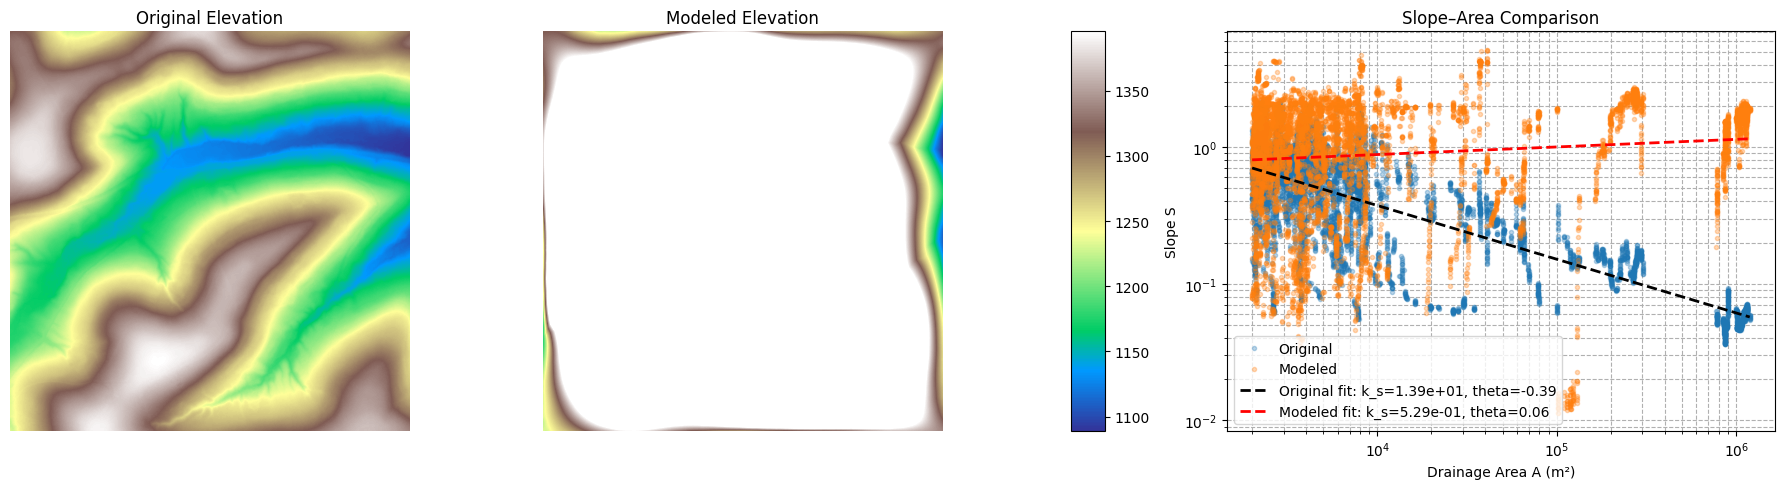

[saved optimized grids with prefix 'data/tile5/outputs/AP_1m_best_tile_AD-no-opt']


In [2]:
from plotting import plot_maps_area_slope

Z_model = advection_diffusion(U, K0, D0)
plot_maps_area_slope(dem, area, flow_direction, Z_model)

if SAVE:
    base_save = "../../data/AP/tile5/outputs/"
    # 1) Make an Elevation object from Z_model using the original DEM as a template
    dem_opt = copy.copy(dem)              # shallow copy keeps metadata
    dem_opt._griddata = Z_model.astype(float)  # swap in optimized elevations

    # 2) Choose a prefix for all the derived grids
    prefix = base_save + "AP_1m_best_tile_AD-no-opt"  # customize as you like

    # 3) Run your usual processing chain on the optimized DEM
    dem_opt.save(prefix + '_elevation')

    filled = d.FilledElevation(elevation=dem_opt)
    filled.save(prefix + '_filled')

    fd = d.FlowDirectionD8(flooded_dem=filled)
    fd.save(prefix + '_flow_direction')

    area_opt = d.Area(flow_direction=fd)
    area_opt.save(prefix + '_area')

    logarea = d.LogArea(area=area_opt)
    logarea.save(prefix + '_logarea')

    hillshade = d.Hillshade(
        elevation=dem_opt,
        inclination=20,
        azimuth=315
    )
    hillshade.save(prefix + '_hillshade')

    print(f"[saved optimized grids with prefix '{prefix}']")

### Given that the advection diffusion equation cannot reproduce the relief in this landscape, what combinations of K and D can?

We set up an optimization problem by comparing measured and modeled elevations across the tile, and minimizing their squared difference by adjusting K and D.

In [3]:
# ─── Optimization ──────────────────────────────────────
misfit_history = []

@lru_cache(maxsize=None)
def solve_advection_diffusion(log10_K, log10_D):
    K, D = 10**log10_K, 10**log10_D
    return advection_diffusion(U, K, D)

def misfit(log10_K, log10_D):
    Z_mod = solve_advection_diffusion(log10_K, log10_D)
    mse = np.nanmean((Z_mod - dem._griddata)**2)
    misfit_history.append((10**log10_K, 10**log10_D, mse))
    return mse

def optimize_KD(K0, D0, K_bounds, D_bounds):
    x0 = np.log10([K0, D0])
    bounds = [tuple(np.log10(K_bounds)), tuple(np.log10(D_bounds))]
    res = minimize(lambda x: misfit(*x), x0, method="L-BFGS-B", bounds=bounds)
    return 10**res.x[0], 10**res.x[1], res.fun

K_star, D_star, mse_star = optimize_KD(K0, D0, K_bounds, D_bounds)
print("\n🎉 Optimal parameters:")
print(f"   K = {K_star:.4e}")
print(f"   D = {D_star:.4e}")
print(f"   MSE = {mse_star:.4e}")


🎉 Optimal parameters:
   K = 1.5615e-05
   D = 4.3162e-05
   MSE = 1.0053e+03


completed flow graph in: 9.920411109924316 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100completed flow graph in: 9.720644474029541 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100

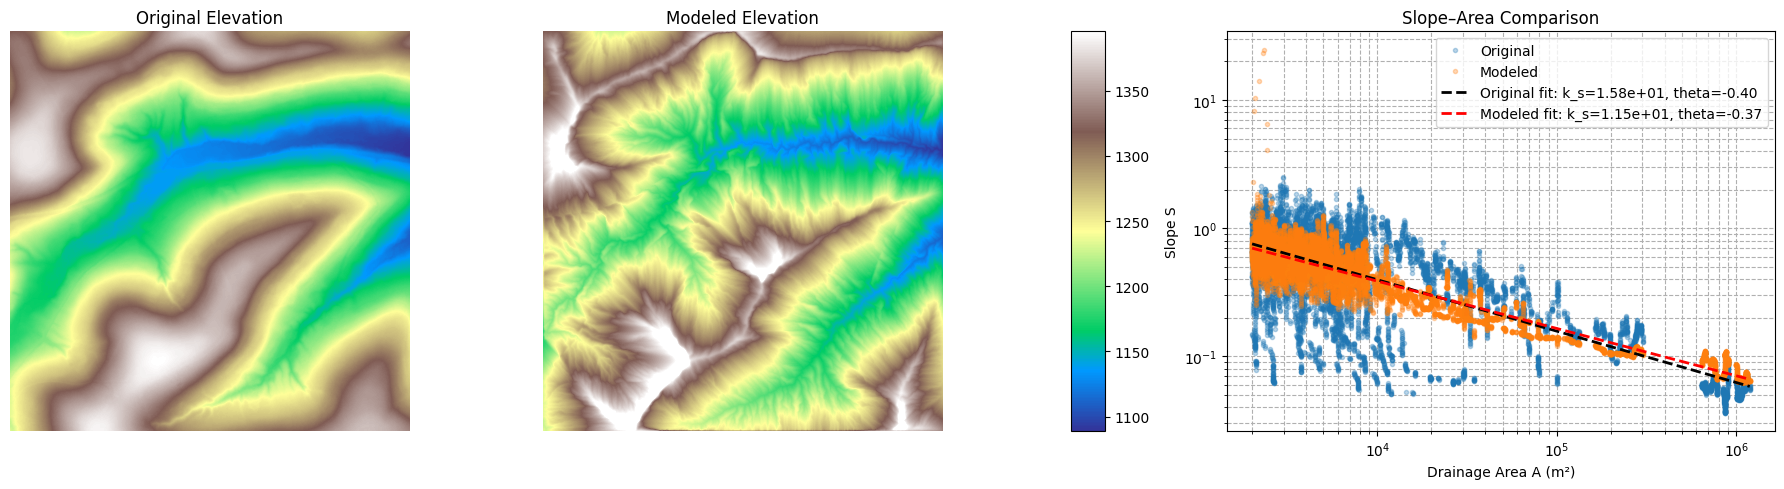

[saved optimized grids with prefix 'data/tile5/outputs/AP_1m_best_tile_AD-opt']


In [4]:
Z_model = advection_diffusion(U, K_star, D_star)

plot_maps_area_slope(dem, area, flow_direction, Z_model)

if SAVE:
    # 1) Make an Elevation object from Z_model using the original DEM as a template
    dem_opt = copy.copy(dem)              # shallow copy keeps metadata
    dem_opt._griddata = Z_model.astype(float)  # swap in optimized elevations

    # 2) Choose a prefix for all the derived grids
    prefix = base_save + "AP_1m_best_tile_AD-opt"  # customize as you like

    # 3) Run your usual processing chain on the optimized DEM
    dem_opt.save(prefix + '_elevation')

    filled = d.FilledElevation(elevation=dem_opt)
    filled.save(prefix + '_filled')

    fd = d.FlowDirectionD8(flooded_dem=filled)
    fd.save(prefix + '_flow_direction')

    area_opt = d.Area(flow_direction=fd)
    area_opt.save(prefix + '_area')

    logarea = d.LogArea(area=area_opt)
    logarea.save(prefix + '_logarea')

    hillshade = d.Hillshade(
        elevation=dem_opt,
        inclination=20,
        azimuth=315
    )
    hillshade.save(prefix + '_hillshade')

    print(f"[saved optimized grids with prefix '{prefix}']")

# Trying Several Bounds

## We next consider the threshold landscape model.  In this case, diffusion acts in areas of the landscape where $ A \le A_{crit}$ whereas incision occurs where $A > A_{crit}$.  

We first explore the topography expected from Peron's K, D values for the Gabilans for differing $A_{crit}$.

In [5]:
from models import partitioned_threshold_model
from utils import crop
import importlib
import plotting
importlib.reload(plotting)
from plotting import plot_maps_and_channel_mask

# re-enstate true intitial values
K0, D0 = np.power(U/steepness,1/n), U/hilltop_curvature

partitioned_model = partitioned_threshold_model(dem, area, flow_direction, m, U, K0)

Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***


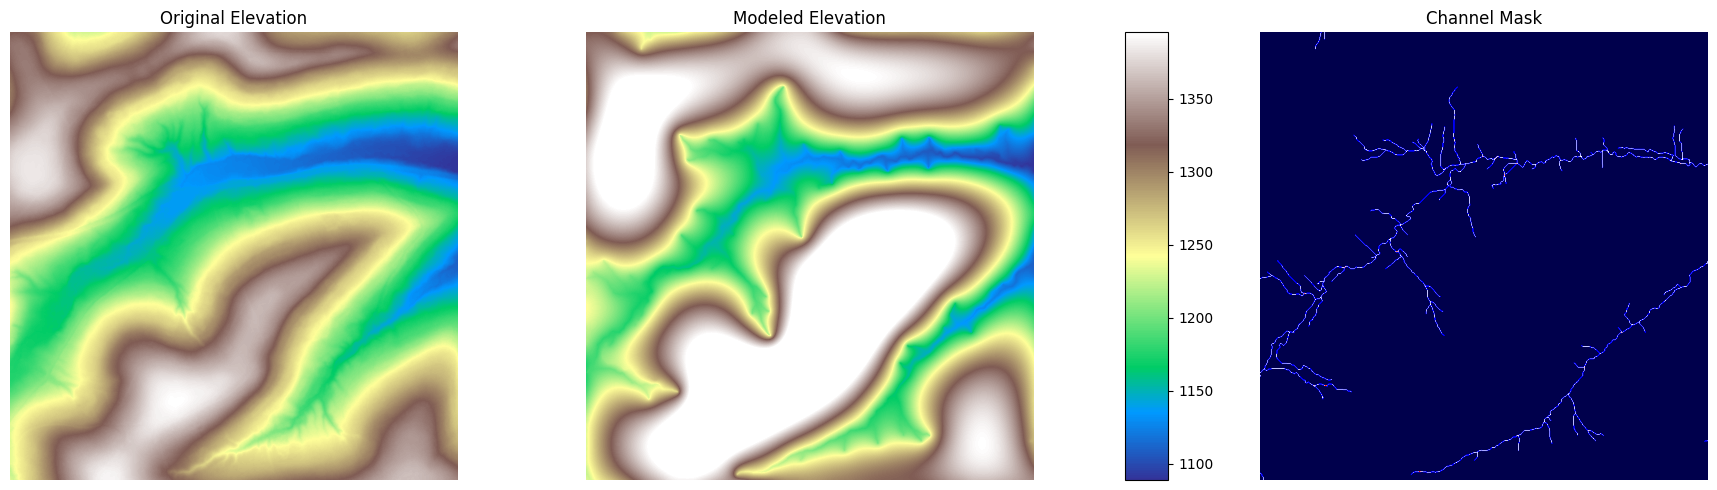

In [6]:
A_crit = 5E3

Z_model, mask = partitioned_model(A_crit, D0)

plot_maps_and_channel_mask(dem, Z_model, mask)

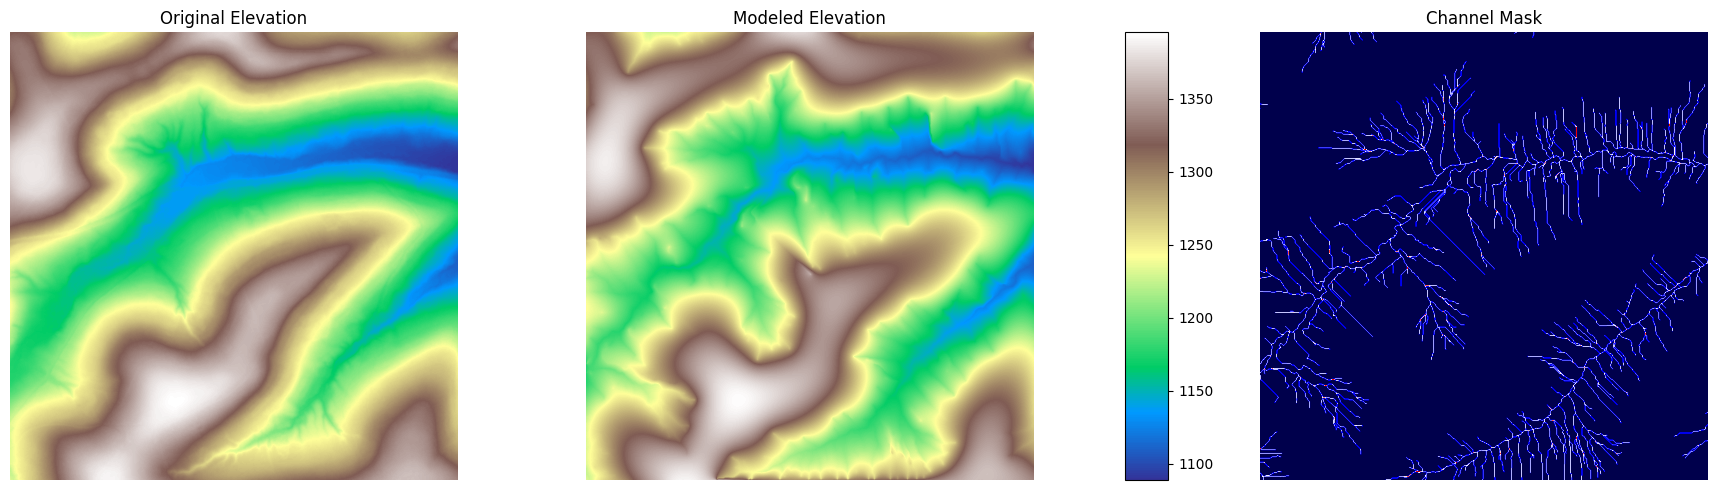

In [7]:
A_crit = 1E3 # 

Z_model, mask = partitioned_model(A_crit, D0)

plot_maps_and_channel_mask(dem, Z_model, mask)

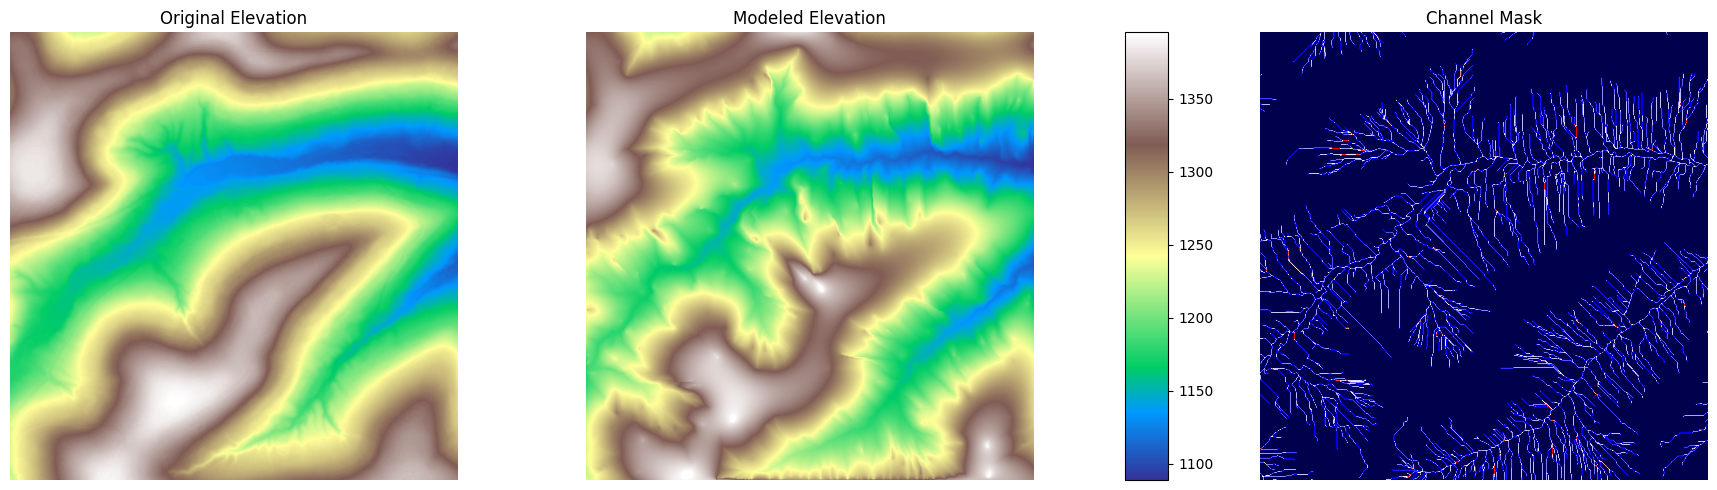

In [8]:
A_crit = 5E2 # 

Z_model, mask = partitioned_model(A_crit, D0)

plot_maps_and_channel_mask(dem, Z_model, mask)

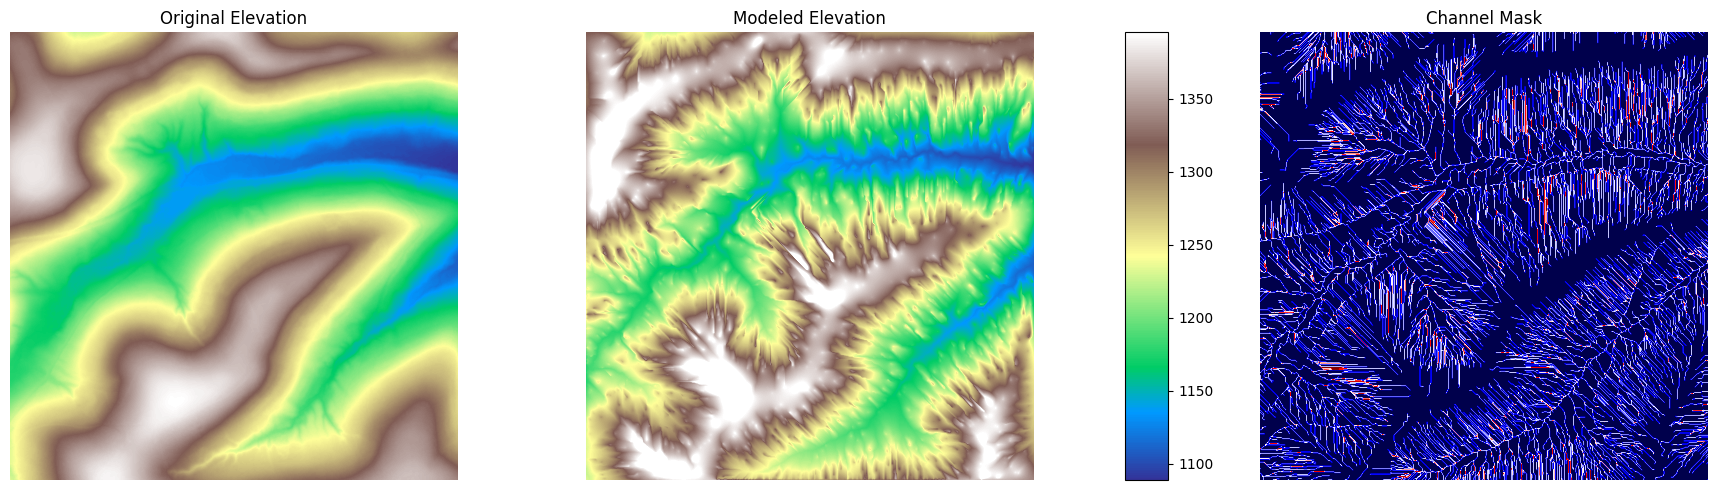

In [9]:
A_crit = 1E2 # 

Z_model, mask = partitioned_model(A_crit, D0)

plot_maps_and_channel_mask(dem, Z_model, mask)

### Next, we optimize as before by varying $A_{crit}$ to find best-fitting topography.

In [10]:
from scipy.optimize import minimize

import numpy as np
from functools import lru_cache

@lru_cache(maxsize=None)
def solve_partitioned_model(log10_A_crit):
    A_crit = 10**log10_A_crit
    zmod, _ = partitioned_model(A_crit, D0)
    return zmod

def misfit(log10_A_crit):
    Z_mod = solve_partitioned_model(log10_A_crit)
    mse = np.nanmean((Z_mod - dem._griddata)**2)
    return mse

A_crit_0 = 5000
A_crit_bounds = (1E2, 1E5)

def optimize_partitioned_model(A_crit_0, A_crit_bounds):
    x0 = np.log10([A_crit_0])
    bounds = [tuple(np.log10(A_crit_bounds))]
    res = minimize(lambda x: misfit(*x), x0, method="Nelder-Mead", bounds=bounds)
    return 10**res.x[0], res.fun

A_crit_star, mse_star = optimize_partitioned_model(A_crit_0, A_crit_bounds)
print("\n🎉 Optimal parameters:")
print(f"   A_crit = {A_crit_star:.4e}")
print(f"   MSE = {mse_star:.4e}")


🎉 Optimal parameters:
   A_crit = 1.1300e+03
   MSE = 3.5926e+02


completed flow graph in: 9.719035148620605 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100completed flow graph in: 9.93317985534668 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100

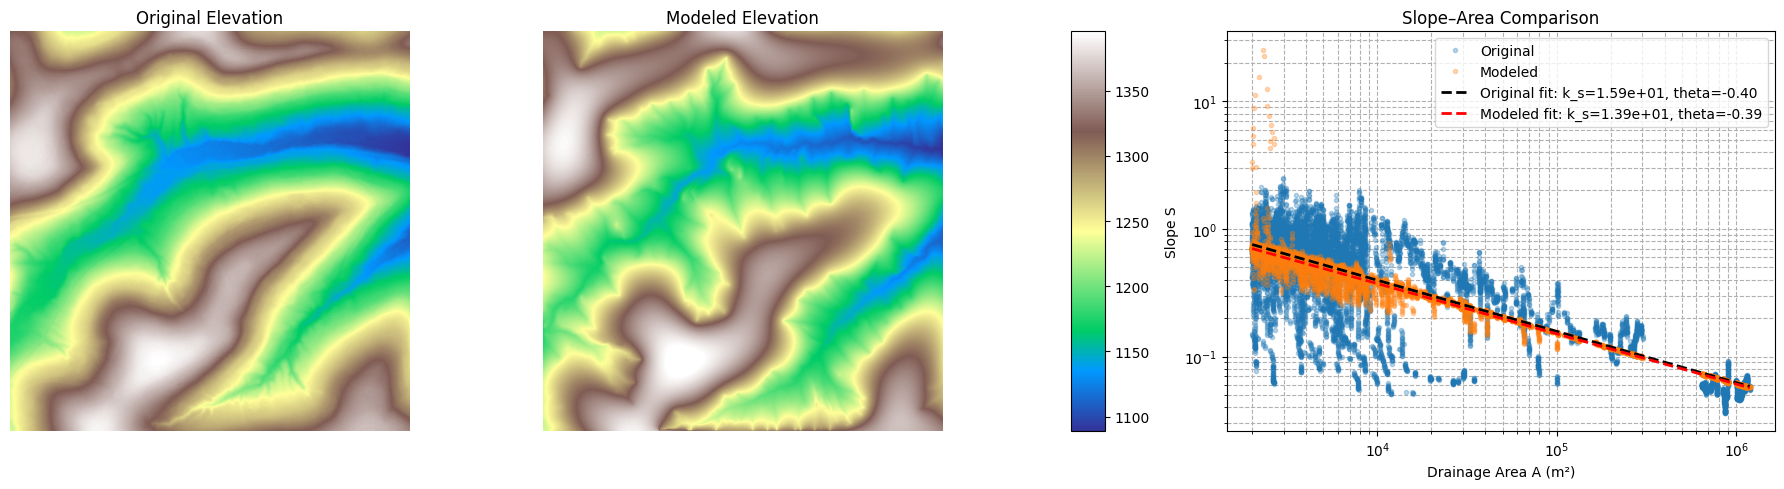

[saved optimized grids with prefix 'data/tile5/outputs/AP_1m_best_tile_Partitioned-model-a_crit-opt']


In [11]:
from scipy.stats import linregress

# ─── Plotting ──────────────────────────────────────
Z_model, channel_mask = partitioned_model(A_crit_star, D0)

plot_maps_area_slope(dem, area, flow_direction, Z_model, channel_mask)

if SAVE:
    # 1) Make an Elevation object from Z_model using the original DEM as a template
    dem_opt = copy.copy(dem)              # shallow copy keeps metadata
    dem_opt._griddata = Z_model.astype(float)  # swap in optimized elevations

    # 2) Choose a prefix for all the derived grids
    prefix = base_save + "AP_1m_best_tile_Partitioned-model-a_crit-opt"  # customize as you like

    # 3) Run your usual processing chain on the optimized DEM
    dem_opt.save(prefix + '_elevation')

    filled = d.FilledElevation(elevation=dem_opt)
    filled.save(prefix + '_filled')

    fd = d.FlowDirectionD8(flooded_dem=filled)
    fd.save(prefix + '_flow_direction')

    area_opt = d.Area(flow_direction=fd)
    area_opt.save(prefix + '_area')

    logarea = d.LogArea(area=area_opt)
    logarea.save(prefix + '_logarea')

    hillshade = d.Hillshade(
        elevation=dem_opt,
        inclination=20,
        azimuth=315
    )
    hillshade.save(prefix + '_hillshade')

    print(f"[saved optimized grids with prefix '{prefix}']")

## The next set of experiments will be to examine the impact of non-linear diffusion on the best-fitting topography.

We'll first do a general exploration of the role of non-linear diffusion on the topography.

First, let's determine the slope distributions for the best-fitting model to determine whether they may produce substantial non-linear hillslope transport.

(array([ 3521., 15605., 25815., 30134., 44231., 65063., 82784., 92498.,
        99666., 97528., 86755., 74627., 60394., 50275., 39756., 31193.,
        24172., 17375., 13405.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
 <BarContainer object of 19 artists>)

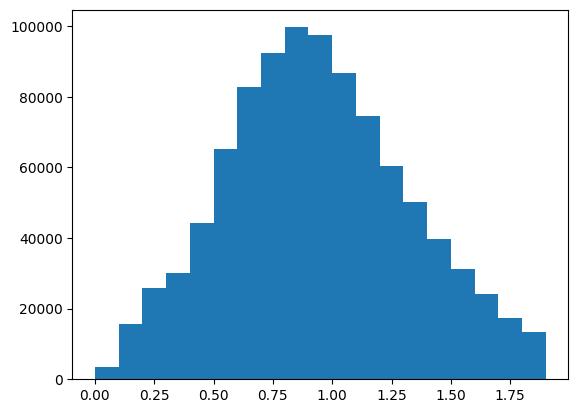

In [12]:
hillslope_mask = ~channel_mask

[gx, gy] = np.gradient(Z_model)
s = np.power(np.power(gx,2) + np.power(gy,2), 1/2)
plt.hist(s[hillslope_mask], bins = np.arange(0,2,0.1))

(array([ 64505., 130351., 131215.,  94739.,  68009.,  47464.,  33508.,
         25935.,  19687.,  15377.,  12627.,  10788.,   9030.,   7792.,
          6577.,   5641.,   4880.,   4347.,   3849.,   3573.,   3137.,
          2780.,   2514.,   2428.,   2110.,   1973.,   1789.,   1606.,
          1600.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029]),
 <BarContainer object of 29 artists>)

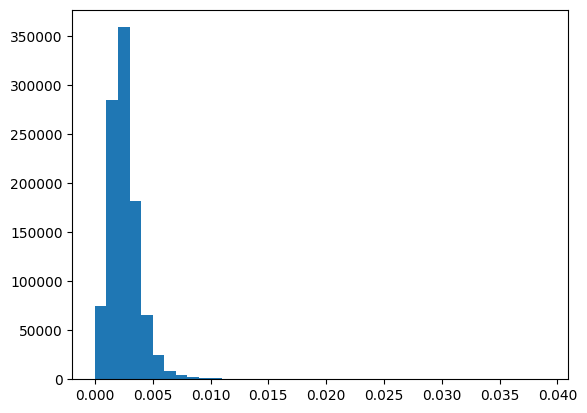

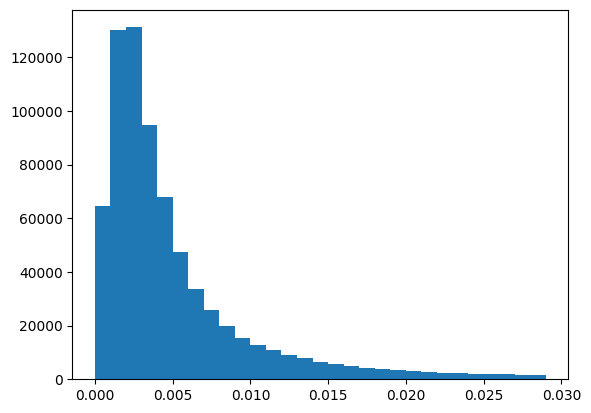

In [13]:
Sc = 1.27

plt.figure()
plt.hist(D0*s[hillslope_mask], bins = np.arange(0,0.04,0.001))
plt.figure()
plt.hist(s[hillslope_mask]*D0 / (1 - np.power(s[hillslope_mask]/Sc,2)), bins = np.arange(0, 0.03, 0.001))

### Next, let's perform a forward exploration of the effect of non-linear transport and how this might vary with A_crit.

In [14]:
from models import partitioned_threshold_model_nonlinear

Sc = 1.27

partitioned_model_nonlinear = partitioned_threshold_model_nonlinear(dem, area, flow_direction, m, U, K0)

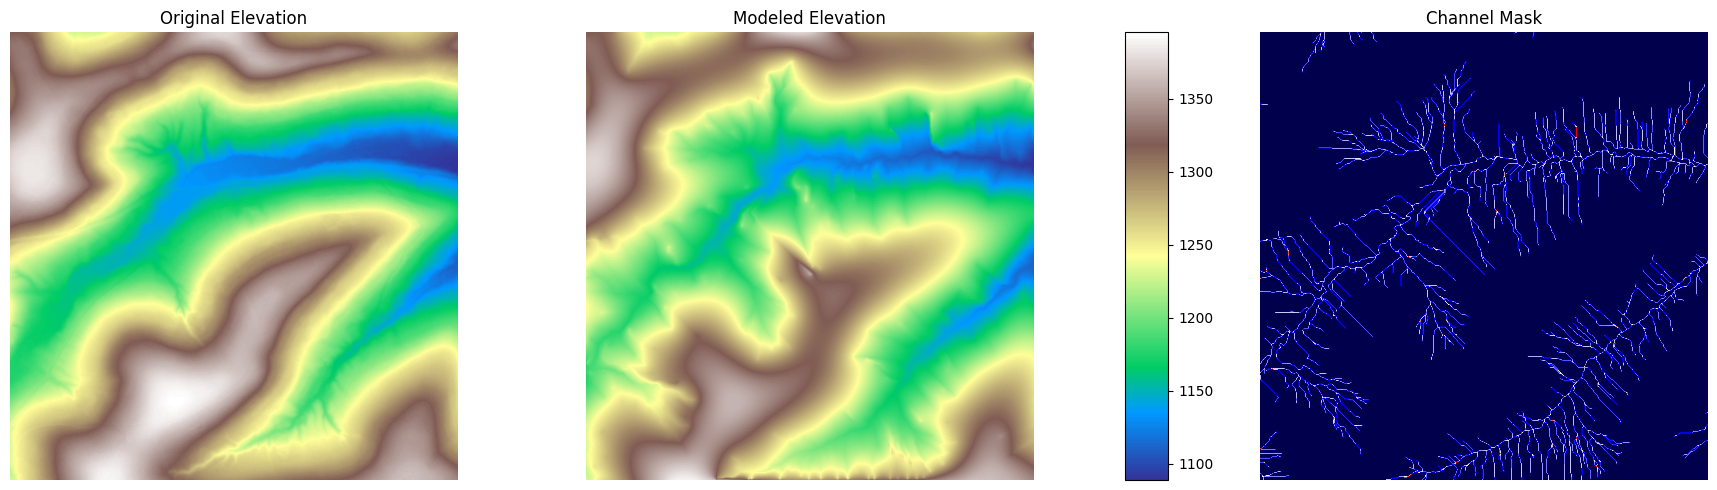

In [15]:
A_crit = 1E3

Z_model, mask = partitioned_model_nonlinear(A_crit, D0, Sc)

plot_maps_and_channel_mask(dem, Z_model, mask)

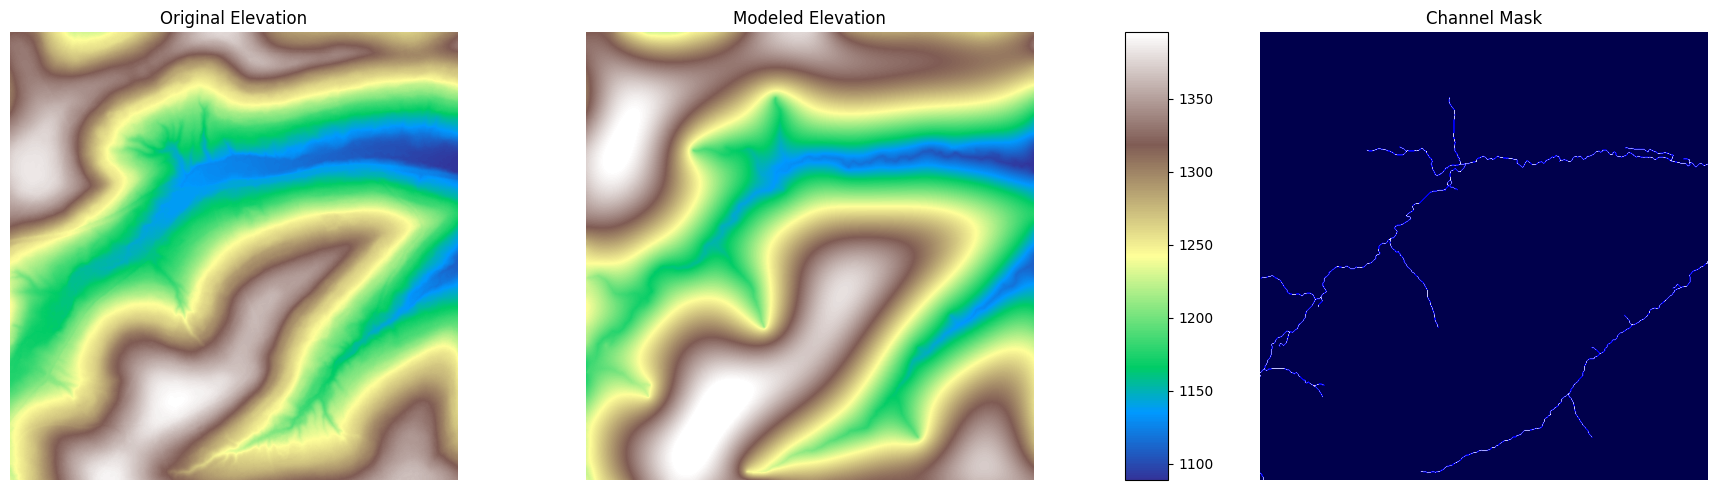

In [16]:
A_crit = 1E4

Z_model, mask = partitioned_model_nonlinear(A_crit, D0, Sc)

plot_maps_and_channel_mask(dem, Z_model, mask)

### Let's next repeat the optimization of $A_{crit}$ using the nonlinear diffusion framework.

In [17]:
from scipy.optimize import minimize

import numpy as np
from functools import lru_cache

@lru_cache(maxsize=None)
def solve_partitioned_model_nonlinear(log10_A_crit):
    A_crit = 10**log10_A_crit
    zmod, _ = partitioned_model_nonlinear(A_crit, D0, Sc)
    return zmod

def misfit(log10_A_crit):
    Z_mod = solve_partitioned_model_nonlinear(log10_A_crit)
    mse = np.nanmean((Z_mod - dem._griddata)**2)
    return mse

A_crit_0 = 5000
A_crit_bounds = (1E2, 1E5)

def optimize_partitioned_model(A_crit_0, A_crit_bounds):
    x0 = np.log10([A_crit_0])
    bounds = [tuple(np.log10(A_crit_bounds))]
    res = minimize(lambda x: misfit(*x), x0, method="Nelder-Mead", bounds=bounds)
    return 10**res.x[0], res.fun

A_crit_star, mse_star = optimize_partitioned_model(A_crit_0, A_crit_bounds)
print("\n🎉 Optimal parameters:")
print(f"   A_crit = {A_crit_star:.4e}")
print(f"   MSE = {mse_star:.4e}")


🎉 Optimal parameters:
   A_crit = 3.3991e+03
   MSE = 2.6138e+02


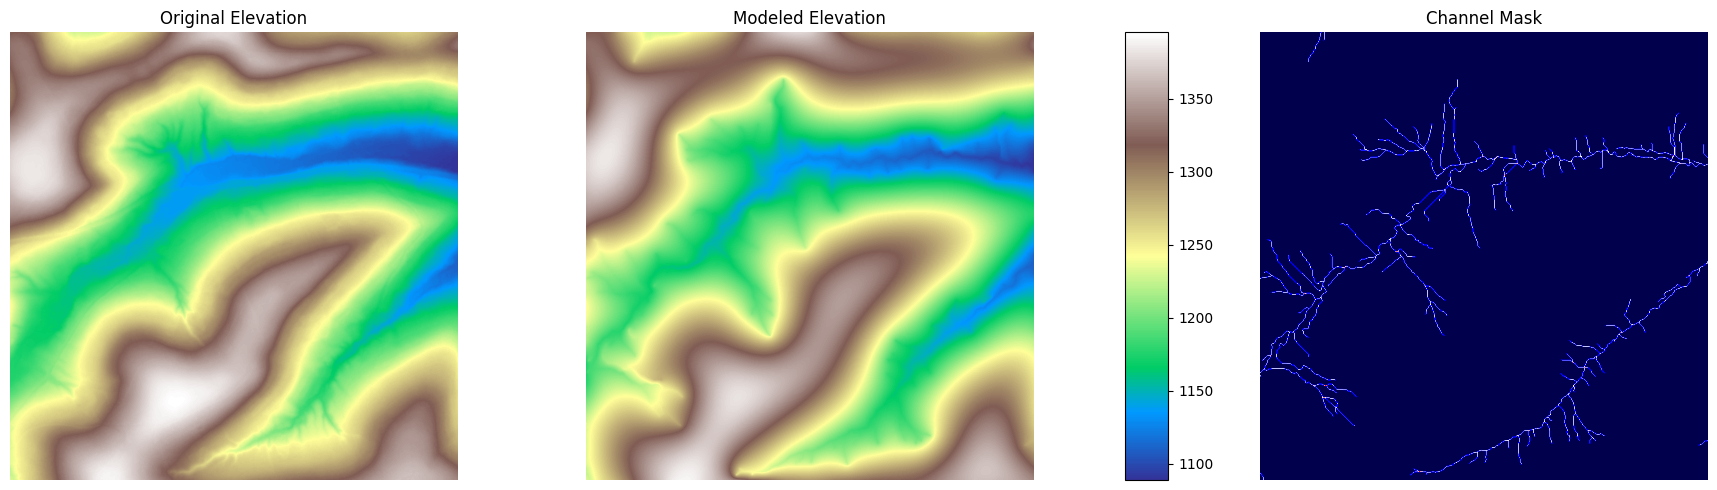

In [18]:
Z_model, mask = partitioned_model_nonlinear(A_crit_star, D0, Sc)

plot_maps_and_channel_mask(dem, Z_model, mask)

### The nonlinear model does a bit better than the linear model, which in turn is better than the advection diffusion model.

Let's perform a final set of experiments in which we allow K and D (and $A_{crit}$) to vary to optimize the topography within the context of the threshold landscape model.

In [19]:
A_crit_0 = 5000
A_crit_bounds = (1E2, 1E5)


@lru_cache(maxsize=None)
def solve_partitioned_model_all(log10_A_crit, log10_D, log10_K):
    A_crit = 10**log10_A_crit
    D = 10**log10_D
    K = 10**log10_K
    partitioned_model_all = partitioned_threshold_model(dem, area, flow_direction, m, U, K)
    zmod, _ = partitioned_model_all(A_crit, D)
    return zmod

def misfit(log10_A_crit, log10_D, log10_K):
    Z_mod = solve_partitioned_model_all(log10_A_crit, log10_D, log10_K)
    mse = np.nanmean((Z_mod - dem._griddata)**2)
    return mse

def optimize_partitioned_model_all(A_crit_0, D0, K0, A_crit_bounds, D_bounds, K_bounds):
    x0 = np.log10([A_crit_0, D0, K0])
    bounds = [tuple(np.log10(A_crit_bounds)), tuple(np.log10(D_bounds)), tuple(np.log10(K_bounds))]
    res = minimize(lambda x: misfit(*x), x0, method="Nelder-Mead", bounds=bounds)
    return 10**res.x[0], 10**res.x[1], 10** res.x[2], res.fun

A_crit_star, D_star, K_star, mse_star = optimize_partitioned_model_all(A_crit_0, D0, K0, A_crit_bounds, D_bounds, K_bounds)
print("\n🎉 Optimal parameters:")
print(f"   D = {D_star:.4e}")
print(f"   K = {K_star:.4e}")
print(f"   A_crit = {A_crit_star:.4e}")
print(f"   MSE = {mse_star:.4e}")

Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=

First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow dir

Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=

First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow dir

Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=

First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow dir

Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=

First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow dir

Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=

First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow dir

Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=

First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow dir

Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=

First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow dir

Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=

First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow dir

Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=

First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow dir


🎉 Optimal parameters:
   D = 3.6291e-03
   K = 3.4402e-06
   A_crit = 1.8870e+03
   MSE = 2.8962e+02


Starting channel propagation with 4056 boundary cells
Boundary seeds by edge: {'first_row_j0': 1015, 'last_row_jmax': 1015, 'left_i0': 1013, 'right_imax': 1013}
  first_row_j0 = j=0, last_row_jmax = j=1014
Channel propagation completed: 1026169 cells processed
Final channel NaNs: 0/1030225
First row (j=0) channel NaNs: 0/1015
Last row (j=1014) channel NaNs: 0/1015

*** DISCONNECTED FLOW ANALYSIS ***
Cells processed by propagation: 1026169
Cells with NaN channel elevations: 0
Total valid cells in grid: 1030225
Cells unreachable from boundaries: 0
Cells with no downstream connection: 2051
*** These cells have invalid flow directions or flow off-grid ***
completed flow graph in: 9.889183759689331 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100completed flow graph in: 9.935073614120483 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100

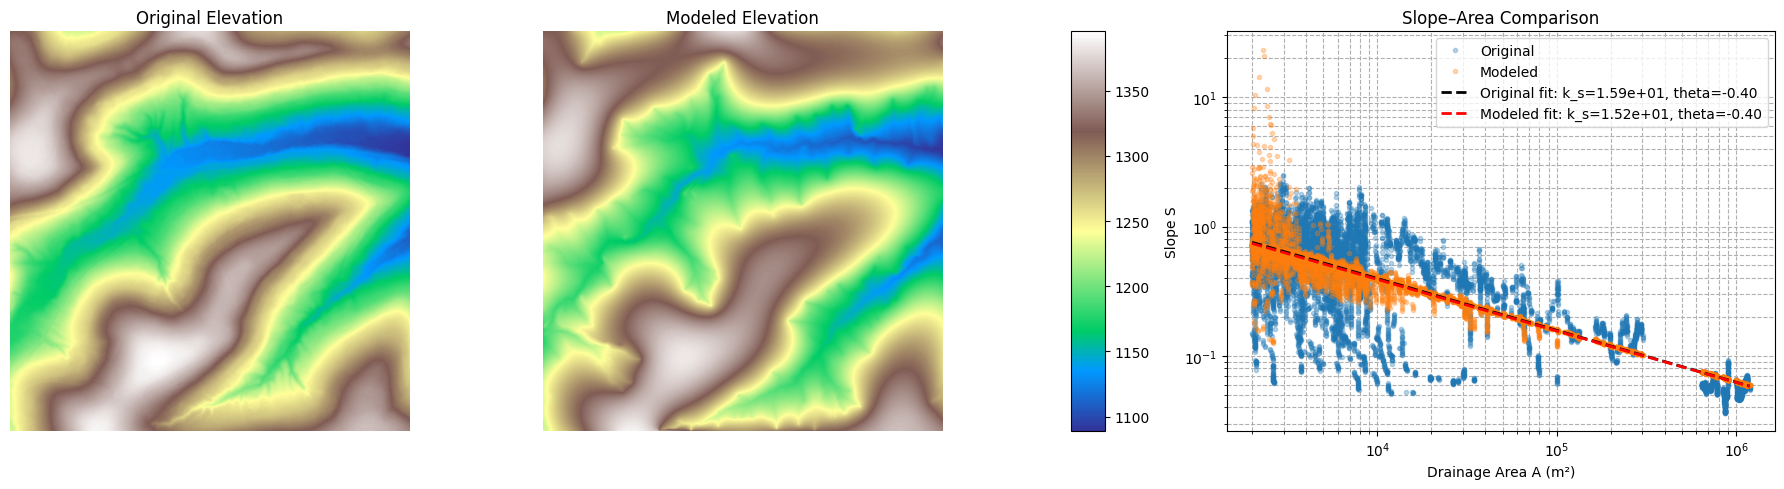

[saved optimized grids with prefix 'data/tile5/outputs/AP_1m_best_tile_Partitioned-model-a_crit-k-d-opt']


In [20]:
partitioned_model_all = partitioned_threshold_model(dem, area, flow_direction, m, U, K_star)

Z_model, channel_mask = partitioned_model_all(A_crit_star, D_star)

plot_maps_area_slope(dem, area, flow_direction, Z_model, channel_mask)

if SAVE:
    # 1) Make an Elevation object from Z_model using the original DEM as a template
    dem_opt = copy.copy(dem)              # shallow copy keeps metadata
    dem_opt._griddata = Z_model.astype(float)  # swap in optimized elevations

    # 2) Choose a prefix for all the derived grids
    prefix = base_save + "AP_1m_best_tile_Partitioned-model-a_crit-k-d-opt"  # customize as you like

    # 3) Run your usual processing chain on the optimized DEM
    dem_opt.save(prefix + '_elevation')

    filled = d.FilledElevation(elevation=dem_opt)
    filled.save(prefix + '_filled')

    fd = d.FlowDirectionD8(flooded_dem=filled)
    fd.save(prefix + '_flow_direction')

    area_opt = d.Area(flow_direction=fd)
    area_opt.save(prefix + '_area')

    logarea = d.LogArea(area=area_opt)
    logarea.save(prefix + '_logarea')

    hillshade = d.Hillshade(
        elevation=dem_opt,
        inclination=20,
        azimuth=315
    )
    hillshade.save(prefix + '_hillshade')

    print(f"[saved optimized grids with prefix '{prefix}']")